In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_apple = pd.read_csv("AAPL.csv", index_col='date', parse_dates=['date'])
data_apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9669 entries, 2019-04-18 to 1980-12-12
Data columns (total 6 columns):
volume      9669 non-null int64
open        9669 non-null float64
close       9669 non-null float64
high        9669 non-null float64
low         9669 non-null float64
adjclose    9669 non-null float64
dtypes: float64(5), int64(1)
memory usage: 528.8 KB


In [3]:
data_apple.head()

,volume,open,close,high,low,adjclose
date,,,,,,
2019-04-18,24195800,203.119995,203.860001,204.149994,202.520004,203.860001
2019-04-17,28906800,199.539993,203.130005,203.380005,198.610001,203.130005
2019-04-16,25696400,199.460007,199.250000,201.369995,198.559998,199.250000
2019-04-15,17536600,198.580002,199.229996,199.850006,198.009995,199.229996
2019-04-12,27760700,199.199997,198.869995,200.139999,196.210007,198.869995


In [4]:
data_apple.tail()

,volume,open,close,high,low,adjclose
date,,,,,,
1980-12-18,18362400,0.475446,0.475446,0.477679,0.475446,0.021307
1980-12-17,21610400,0.462054,0.462054,0.464286,0.462054,0.020706
1980-12-16,26432000,0.453125,0.450893,0.453125,0.450893,0.020206
1980-12-15,43971200,0.488839,0.486607,0.488839,0.486607,0.021807
1980-12-12,117258400,0.513393,0.513393,0.515625,0.513393,0.023007


In [5]:
#Since our dataset starts from 2019 to 1980, we want to reverse it
reversed_data_apple = data_apple.iloc[::-1]

In [58]:
training_set = reversed_data_apple['2006':'2017'].iloc[:,3:4].values
test_set = reversed_data_apple['2018':].iloc[:,3:4].values

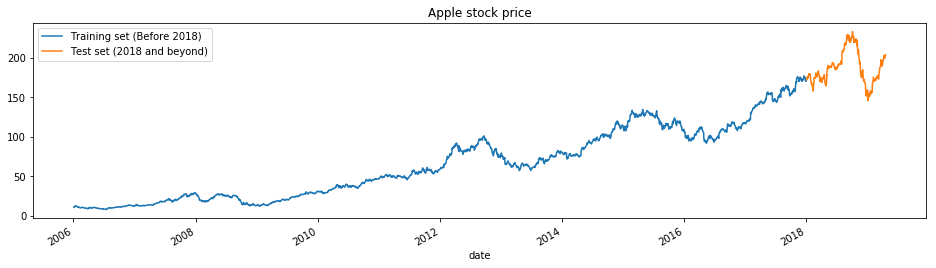

In [7]:
reversed_data_apple["high"]['2006':'2017'].plot(figsize=(16,4),legend=True)
reversed_data_apple["high"]['2018':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('Apple stock price')
plt.show()

We chose Apple as the target company for our project. We have 9669 entries and 6 features in this Apple dataset, but we are not going to use them all. We have chosen 'High' attribute for prices and limit the time (from 2006 to latest).

In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [9]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
apple_training_scaled  = sc.fit_transform(training_set)

In [11]:
# Since LSTM's store long term memory state, we create a data structure with 30 timesteps and 1 output
# So for each element of training set, we have 30 previous training set elements 
# We could also use other number for inputs, f.ex. 50 or 60. We chose 30 because it takes less time and has decent results
X_train = []
y_train = []

previous = 30

for i in range(previous, len(apple_training_scaled)):
    X_train.append(apple_training_scaled[i-previous:i,0])
    y_train.append(apple_training_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(2990, 30, 1)

In [13]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2990/2990 [==============================] - 10s 3ms/step - loss: 0.0154
Epoch 2/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0026
Epoch 3/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0021
Epoch 4/50
2990/2990 [==============================] - 9s 3ms/step - loss: 0.0021
Epoch 5/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0021
Epoch 6/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0019
Epoch 7/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0020
Epoch 8/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0017
Epoch 9/50
2990/2990 [==============================] - 8s 3ms/step - loss: 0.0014
Epoch 10/50
2990/

In [95]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
data_apple_total = pd.concat((reversed_data_apple["high"][:'2017'],reversed_data_apple["high"]['2018':]),axis=0)
inputs = data_apple_total[len(data_apple_total) - len(test_set) - previous:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [15]:
# Preparing X_test and predicting the prices
X_test = []

for i in range(previous, len(inputs)):
    X_test.append(inputs[i-previous:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

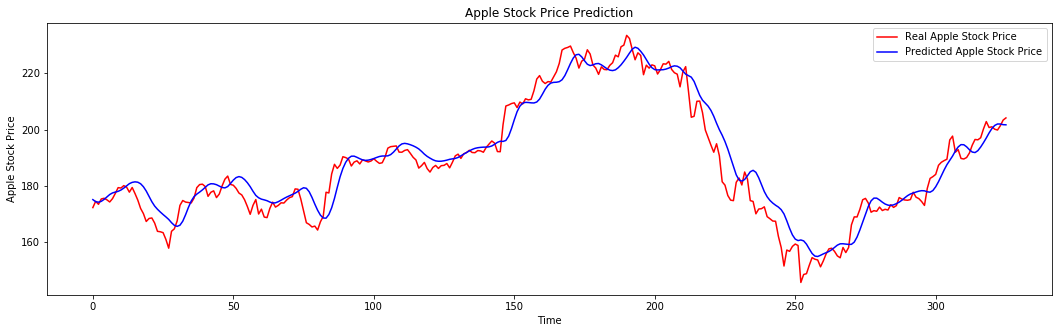

In [16]:
# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real '+ 'Apple Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted '+'Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [17]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 5.505497460079869.


In the graph, it seems like there is a delay in this prediction, which is correct, since there is a typical problem in LSTM for time series prediction(1-step lag predictor). The possible solution for it is **do not give the prices directly** to the algorithm. The point is do not give direct intuition to what it should predict, only provide patterns for algorithm to work on. So we will start with a new data preprocessing and make a new prediction.

### Data preprocessing for new prediction

In [391]:
# Inflation adjustment
data_inflation = pd.read_csv("INFLATION_USA.csv", index_col='Date', parse_dates=['Date'])
data_inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1263 entries, 2019-04-30 to 1914-02-28
Data columns (total 1 columns):
Value    1241 non-null float64
dtypes: float64(1)
memory usage: 19.7 KB


In [392]:
data_inflation.head()

,Value
Date,
2019-04-30,0.071390
2019-03-31,0.225658
2019-02-28,-0.019987
2019-01-31,-0.187958
2018-12-31,-0.122646


In [409]:
new_data_apple = data_apple.merge(data_inflation, left_index=True, right_index=True)
new_data_apple.head(100)

,volume,open,close,high,low,adjclose,Value
2019-02-28,28215400,174.320007,173.149994,174.910004,172.919998,173.149994,-0.019987
2019-01-31,40739600,166.110001,166.440002,169.000000,164.559998,165.729218,-0.187958
2018-12-31,35003500,158.529999,157.740005,159.360001,156.479996,157.066376,-0.122646
2018-11-30,39531500,180.289993,178.580002,180.330002,177.029999,177.817383,-0.136796
2018-10-31,38358900,216.880005,218.860001,220.449997,216.619995,217.167618,0.107598
2018-08-31,43340100,226.509995,227.630005,228.869995,226.000000,225.869812,-0.085085
2018-07-31,39373000,190.300003,190.289993,192.139999,189.339996,188.158646,0.027159
2018-05-31,27482800,187.220001,186.869995,188.229996,186.139999,184.776947,0.137231
2018-04-30,42427400,162.130005,165.259995,167.259995,161.839996,162.781296,0.043644
2018-02-28,37782100,179.259995,178.119995,180.619995,178.050003,175.448410,0.068083


In [394]:
# Price adjust by inflation
new_data_apple['RealPrice'] = new_data_apple.high + (new_data_apple.high * new_data_apple.Value)
new_data_apple.head()

,volume,open,close,high,low,adjclose,Value,RealPrice
2019-02-28,28215400,174.320007,173.149994,174.910004,172.919998,173.149994,-0.019987,171.414059
2019-01-31,40739600,166.110001,166.440002,169.000000,164.559998,165.729218,-0.187958,137.235079
2018-12-31,35003500,158.529999,157.740005,159.360001,156.479996,157.066376,-0.122646,139.815159
2018-11-30,39531500,180.289993,178.580002,180.330002,177.029999,177.817383,-0.136796,155.661544
2018-10-31,38358900,216.880005,218.860001,220.449997,216.619995,217.167618,0.107598,244.169913


In [395]:
# Ratio to its volume
new_data_apple['Ratio'] = new_data_apple.volume / new_data_apple.RealPrice
new_data_apple.head()

,volume,open,close,high,low,adjclose,Value,RealPrice,Ratio
2019-02-28,28215400,174.320007,173.149994,174.910004,172.919998,173.149994,-0.019987,171.414059,164603.767967
2019-01-31,40739600,166.110001,166.440002,169.000000,164.559998,165.729218,-0.187958,137.235079,296859.960552
2018-12-31,35003500,158.529999,157.740005,159.360001,156.479996,157.066376,-0.122646,139.815159,250355.542616
2018-11-30,39531500,180.289993,178.580002,180.330002,177.029999,177.817383,-0.136796,155.661544,253958.036021
2018-10-31,38358900,216.880005,218.860001,220.449997,216.619995,217.167618,0.107598,244.169913,157099.208092


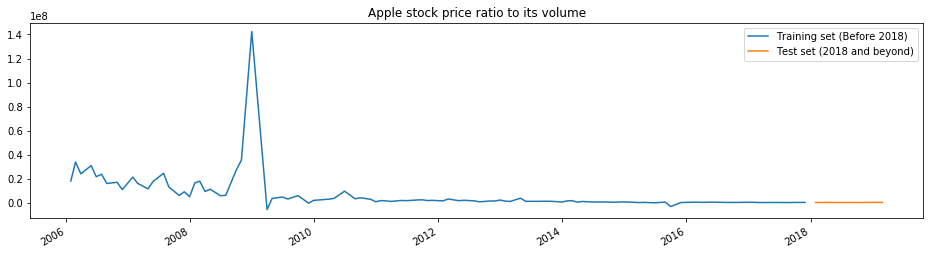

In [399]:
# Ratio to its volume
new_data_apple = new_data_apple.round({'Ratio': 2})
new_reversed_data_apple = new_data_apple.iloc[::-1]
new_training_set = new_reversed_data_apple['2006':'2017'].iloc[:,8:9].values
new_test_set = new_reversed_data_apple['2018':].iloc[:,8:9].values
new_reversed_data_apple["Ratio"]['2006':'2017'].plot(figsize=(16,4),legend=True)
new_reversed_data_apple["Ratio"]['2018':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('Apple stock price ratio to its volume')
plt.show()

In [400]:
new_apple_training_scaled  = sc.fit_transform(new_training_set)

X_new_train = []
y_new_train = []

previous = 22

for i in range(previous, len(new_apple_training_scaled)):
    X_new_train.append(new_apple_training_scaled[i-previous:i,0])
    y_new_train.append(new_apple_training_scaled[i,0])
X_new_train, y_new_train = np.array(X_new_train), np.array(y_new_train)

In [401]:
X_new_train = np.reshape(X_new_train, (X_new_train.shape[0],X_new_train.shape[1],1))
X_new_train.shape

(80, 22, 1)

In [402]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_new_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(optimizer='adam',loss='mean_squared_error')
regressor.fit(X_new_train,y_new_train,epochs=50,batch_size=32)

Epoch 1/50
80/80 [==============================] - 12s 144ms/step - loss: 0.0147
Epoch 2/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 6/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 7/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 8/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 9/50
80/80 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 10/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 11/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 12/50
80/80 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 13/50
80/80 [===========================

In [403]:
new_data_apple_total = pd.concat((new_reversed_data_apple["Ratio"][:'2017'],new_reversed_data_apple["Ratio"]['2018':]),axis=0)
new_inputs = new_data_apple_total[len(new_data_apple_total) - len(new_test_set) - previous:].values
new_inputs = new_inputs.reshape(-1,1)
new_inputs = sc.transform(new_inputs)

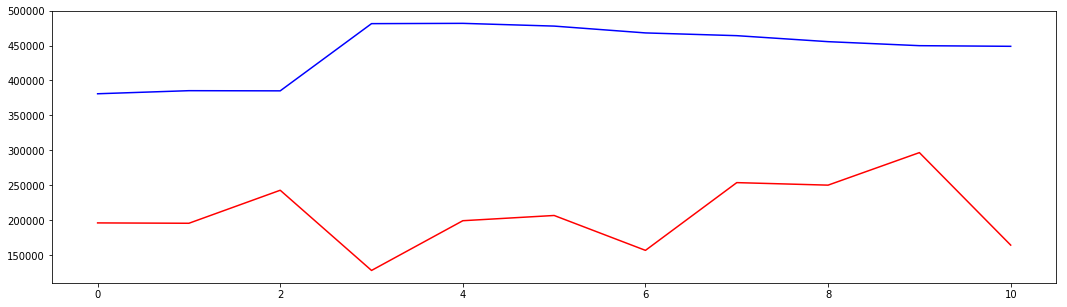

In [405]:
X_new_test = []

for i in range(previous, len(new_inputs)):
    X_new_test.append(new_inputs[i-previous:i,0])
X_new_test = np.array(X_new_test)
X_new_test = np.reshape(X_new_test, (X_new_test.shape[0],X_new_test.shape[1],1))
new_predicted_stock_price = regressor.predict(X_new_test)
new_predicted_stock_price = sc.inverse_transform(new_predicted_stock_price)

plt.figure(figsize=(18,5))
plt.plot(new_test_set[:], color='red',label='Real '+ 'Apple Stock Price')
plt.plot(new_predicted_stock_price[:], color='blue',label='Predicted '+'Apple Stock Price')
plt.show()

In [408]:
rmse = math.sqrt(mean_squared_error(new_test_set, new_predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 243980.054076535.


It seems like this method does not help a lot to forecast a stock. It could be that, I might give the model some other data instead, not just ratios.

Stocks can be affect by many factors i.e., company reports and news, marked news and global news etc.. We can probably use sentiment analysis for collecting those informations as features for our model, but we are not there yet.

### Binary classification

If just the up/down fluctuations are enough, the binary classification might be the best choice.

Since we need to reconstruct the dataset to match the binary classification and there is huge work for that, so we are going to just make a example for what kind of binary classification model can be use here and how it works.

In [ ]:
# KNN Model 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

Knn = KNeighborsClassifier(n_neighbors=3, weights="uniform", algorithm="auto", leaf_size=30, p=2, metric="euclidean", n_jobs=None)
x_train, x_test, y_train, y_test = train_test_split(apple_training_scaled, Y_data, test_size=0.2, random_state=42)
Knn.fit(x_train, y_train)
y_pred = Knn.predict(x_test)
print('Score:', accuracy_score(y_test, y_pred))